## Comparison between original KR algorithm and gcMapExplorer implementation

Here, we compare the results from original KR matrix balancing algorithm with the gcMapExplorer implmentation.


**Note**: Since orignal argorithm is implemented in **MATLAB**, here we used **Octave** for calculation. Also, **oct2py** python module should be installed on the system. 

**Importing required modules:**

* [gcMapExplorer.lib](../apidoc/summary.html)
* [numpy](http://docs.scipy.org/doc/numpy/reference/routines.html) for statistics
* [matplotlib](http://matplotlib.org/gallery.html) for plotting
* [oct2py](https://blink1073.github.io/oct2py/) acts as bridge between Python and Octave, to run original algorithm

In [1]:
import gcMapExplorer.lib as gmlib
import numpy as np
from oct2py import octave

import matplotlib as mpl
import matplotlib.pyplot as plt

# To show inline plots
%matplotlib inline
plt.style.use('ggplot')              # Theme for plotting

***

Here we write **original code** in `norm_KR.m` file in current directory, which will be used below for calculation.

In [2]:

def write_orig_matlab_code():
    
    code = """function [x,res] = norm_KR(A,tol,x0,delta,Delta,fl)
  % BNEWT A balancing algorithm for symmetric matrices
  %
  % X = norm_KR(A) attempts to find a vector X such that
  % diag(X)*A*diag(X) is close to doubly stochastic. A must
  % be symmetric and nonnegative.
  %
  % X0: initial guess. TOL: error tolerance.
  % delta/Delta: how close/far balancing vectors can get
  % to/from the edge of the positive cone.
  % We use a relative measure on the size of elements.
  % FL: intermediate convergence statistics on/off.
  % RES: residual error, measured by norm(diag(x)*A*x - e).

  % Initialise
  n = size(A,1); e = ones(n,1); res=[];
  if nargin < 6, fl = 0; end
  if nargin < 5, Delta = 3; end
  if nargin < 4, delta = 0.1; end
  if nargin < 3, x0 = e; end
  if nargin < 2, tol = 1e-4; end

  % Inner stopping criterion parameters.
  g=0.9; etamax = 0.1;
  eta = etamax; stop_tol = tol*.5;
  x = x0; rt = tol^2; v = x.*(A*x); rk = 1 - v;
  rho_km1 = rk'*rk; rout = rho_km1; rold = rout;
  MVP = 0; % We'll count matrix vector products.
  i = 0; % Outer iteration count.
  if fl == 1, fprintf('it in. it res'), end
  
  while rout > rt % Outer iteration
    i = i + 1; k = 0; y = e;
    innertol = max([eta^2*rout,rt]);
    
    while rho_km1 > innertol %Inner iteration by CG
      k = k + 1;
      if k == 1
        Z = rk./v; p=Z; rho_km1 = rk'*Z;
      else
        beta=rho_km1/rho_km2;
        p=Z + beta*p;
      end
      % Update search direction efficiently.
      w = x.*(A*(x.*p)) + v.*p;
      alpha = rho_km1/(p'*w);
      ap = alpha*p;

      % Test distance to boundary of cone.
      ynew = y + ap;
      if min(ynew) <= delta

        if delta == 0
          break
        end

        ind = find(ap < 0);
        gamma = min((delta - y(ind))./ap(ind));
        y = y + gamma*ap;
        break
      end

      if max(ynew) >= Delta
        ind = find(ynew > Delta);
        gamma = min((Delta-y(ind))./ap(ind));
        y = y + gamma*ap;
        break
      end

      y = ynew;
      rk = rk - alpha*w; rho_km2 = rho_km1;
      Z = rk./v; rho_km1 = rk'*Z;
      
    end

    x = x.*y; v = x.*(A*x);
    rk = 1 - v; rho_km1 = rk'*rk; rout = rho_km1;
    MVP = MVP + k + 1;

    % Update inner iteration stopping criterion.
    rat = rout/rold; rold = rout; res_norm = sqrt(rout);
    eta_o = eta; eta = g*rat;
    if g*eta_o^2 > 0.1
      eta = max([eta,g*eta_o^2]);
    end

    eta = max([min([eta,etamax]),stop_tol/res_norm]);
    if fl == 1
      fprintf('%3d %6d %.3e', i,k, r_norm);
      res=[res; r_norm];
    end
    
  end
  
  fprintf('Matrix-vector products = %6d', MVP)
"""

    fout = open('norm_KR.m', 'w')
    fout.write(code)
    fout.close()

***

**Wrapper function to normalize map using original algorithm**

Follwing function perform several steps:

* Extract a new matrix from input matrix by removing any rows and columns with missing data
* Normalize it using **Octave**
* Construct normalized matrix from normalization vector
* Expand normalized matrix by re-inserting rows and column with missing data

In [3]:
def get_norm_KR_matlab(ccmap):
    # Discard rows and columns with missing data
    ccmap.make_readable()
    bNonZeros = gmlib.ccmapHelpers.get_nonzeros_index(ccmap.matrix)
    A = (ccmap.matrix[bNonZeros,:])[:,bNonZeros]
    
    # Calculate normalization vector using original MATLAB code
    vector = octave.norm_KR(A[:])
    
    # Construct KR normalized matrix using normalization vector
    outA = vector.T * (A * vector)
    
    # Initialize ouput ccmap object
    normCCMap = ccmap.copy(fill=0.0)
    normCCMap.make_editable()
    normCCMap.bNoData = ~bNonZeros

    # Store normalized values to output ccmap
    dsm_i = 0
    ox = normCCMap.matrix.shape[0]
    idx_fill = np.nonzero( ~normCCMap.bNoData )
    for i in range(ox):
        if not normCCMap.bNoData[i]:
            normCCMap.matrix[i, idx_fill] = outA[dsm_i]
            normCCMap.matrix[idx_fill, i] = outA[dsm_i]
            dsm_i += 1

    # Get the maximum and minimum value except zero
    ma = np.ma.masked_equal(outA, 0.0, copy=False)
    normCCMap.minvalue = ma.min()
    normCCMap.maxvalue = ma.max()
    
    normCCMap.make_unreadable()
    ccmap.make_unreadable()
    
    return normCCMap

***

#### Normalization using original Matlab code

Here, we read raw maps from a gcmap file, normalize it using above function and save the normalized maps to output gcmap file.

In [4]:
gcMapInputFile = 'cmaps/CooMatrix/rawObserved_100kb.gcmap'
gcMapOutFile = 'norm_comparison/normKR_matlab.gcmap'
write_orig_matlab_code()

# Get list of maps in ascending order
gcmap = gmlib.gcmap.GCMAP(gcMapInputFile)
gcmap.loadSmallestMap()
mapList = gcmap.mapNameList.copy()
del gcmap

for mapName in mapList:
    print('Calculating for {0}...'.format(mapName))
    ccMap = gmlib.gcmap.loadGCMapAsCCMap(gcMapInputFile, mapName=mapName)
    normKR_ccmap = get_norm_KR_matlab(ccMap)
    
    if normKR_ccmap is not None:
        gmlib.gcmap.addCCMap2GCMap(normKR_ccmap, gcMapOutFile,generateCoarse=True, coarsingMethod='sum',)

    del ccMap
    del normKR_ccmap

Calculating for chr21...
Matrix-vector products =     36


INFO:addCCMap2GCMap: Opened file [norm_comparison/normKR_matlab.gcmap] for reading writing..
INFO:addCCMap2GCMap: Data for chr21 is already present in [norm_comparison/normKR_matlab.gcmap], replacing it... 
INFO:addCCMap2GCMap: Adding data to [norm_comparison/normKR_matlab.gcmap] for [chr21] ...
INFO:addCCMap2GCMap:     ...Finished adding data for [chr21] ...
INFO:addCCMap2GCMap: Generating downsampled maps for [chr21] ...
INFO:addCCMap2GCMap:     ... Finished downsampling for [chr21] ...
INFO:addCCMap2GCMap: Closed file [norm_comparison/normKR_matlab.gcmap]...


Calculating for chr22...
Matrix-vector products =     31


INFO:addCCMap2GCMap: Opened file [norm_comparison/normKR_matlab.gcmap] for reading writing..
INFO:addCCMap2GCMap: Data for chr22 is already present in [norm_comparison/normKR_matlab.gcmap], replacing it... 
INFO:addCCMap2GCMap: Adding data to [norm_comparison/normKR_matlab.gcmap] for [chr22] ...
INFO:addCCMap2GCMap:     ...Finished adding data for [chr22] ...
INFO:addCCMap2GCMap: Generating downsampled maps for [chr22] ...
INFO:addCCMap2GCMap:     ... Finished downsampling for [chr22] ...
INFO:addCCMap2GCMap: Closed file [norm_comparison/normKR_matlab.gcmap]...


Calculating for chr20...
Matrix-vector products =     29


INFO:addCCMap2GCMap: Opened file [norm_comparison/normKR_matlab.gcmap] for reading writing..
INFO:addCCMap2GCMap: Data for chr20 is already present in [norm_comparison/normKR_matlab.gcmap], replacing it... 
INFO:addCCMap2GCMap: Adding data to [norm_comparison/normKR_matlab.gcmap] for [chr20] ...
INFO:addCCMap2GCMap:     ...Finished adding data for [chr20] ...
INFO:addCCMap2GCMap: Generating downsampled maps for [chr20] ...
INFO:addCCMap2GCMap:     ... Finished downsampling for [chr20] ...
INFO:addCCMap2GCMap: Closed file [norm_comparison/normKR_matlab.gcmap]...


Calculating for chr15...
Matrix-vector products =     37


INFO:addCCMap2GCMap: Opened file [norm_comparison/normKR_matlab.gcmap] for reading writing..
INFO:addCCMap2GCMap: Data for chr15 is already present in [norm_comparison/normKR_matlab.gcmap], replacing it... 
INFO:addCCMap2GCMap: Adding data to [norm_comparison/normKR_matlab.gcmap] for [chr15] ...
INFO:addCCMap2GCMap:     ...Finished adding data for [chr15] ...
INFO:addCCMap2GCMap: Generating downsampled maps for [chr15] ...
INFO:addCCMap2GCMap:     ... Finished downsampling for [chr15] ...
INFO:addCCMap2GCMap: Closed file [norm_comparison/normKR_matlab.gcmap]...


Calculating for chr5...
Matrix-vector products =    102


INFO:addCCMap2GCMap: Opened file [norm_comparison/normKR_matlab.gcmap] for reading writing..
INFO:addCCMap2GCMap: Data for chr5 is already present in [norm_comparison/normKR_matlab.gcmap], replacing it... 
INFO:addCCMap2GCMap: Adding data to [norm_comparison/normKR_matlab.gcmap] for [chr5] ...
INFO:addCCMap2GCMap:     ...Finished adding data for [chr5] ...
INFO:addCCMap2GCMap: Generating downsampled maps for [chr5] ...
INFO:addCCMap2GCMap:     ... Finished downsampling for [chr5] ...
INFO:addCCMap2GCMap: Closed file [norm_comparison/normKR_matlab.gcmap]...


Calculating for chr1...
Matrix-vector products =    105


INFO:addCCMap2GCMap: Opened file [norm_comparison/normKR_matlab.gcmap] for reading writing..
INFO:addCCMap2GCMap: Data for chr1 is already present in [norm_comparison/normKR_matlab.gcmap], replacing it... 
INFO:addCCMap2GCMap: Adding data to [norm_comparison/normKR_matlab.gcmap] for [chr1] ...
INFO:addCCMap2GCMap:     ...Finished adding data for [chr1] ...
INFO:addCCMap2GCMap: Generating downsampled maps for [chr1] ...
INFO:addCCMap2GCMap:     ... Finished downsampling for [chr1] ...
INFO:addCCMap2GCMap: Closed file [norm_comparison/normKR_matlab.gcmap]...


#### Correlation Calculation

Below we calculate correlation between above normalized maps (original algorithm) and previously normalized maps (gcMapExplorer implementation).

In [5]:
gcMapOne = 'norm_comparison/normKR_matlab.gcmap'
gcMapTwo = 'normalized/normKR_100kb.gcmap'

mapList, corrs, pvalues = gmlib.cmstats.correlateGCMaps(gcMapOne, gcMapTwo, corrType='pearson')

print('Pearson Correlation gcMapExplorer-KR vs original-KR')
print('====================================================')
print('\nChromosome     Corr      P-values')
print('--------------------------------------------------------')
for i in range(len(mapList)):
    print('{0:5} {1:12.5} {2:12.5}'.format( mapList[i], corrs[i], pvalues[i]))
print('--------------------------------------------------------')

INFO:correlateGCMaps: Performing calculation for chr1 ...
INFO:correlateGCMaps:     Finished calculation for chr1 ...

INFO:correlateGCMaps: Performing calculation for chr5 ...
INFO:correlateGCMaps:     Finished calculation for chr5 ...

INFO:correlateGCMaps: Performing calculation for chr15 ...
INFO:correlateGCMaps:     Finished calculation for chr15 ...

INFO:correlateGCMaps: Performing calculation for chr20 ...
INFO:correlateGCMaps:     Finished calculation for chr20 ...

INFO:correlateGCMaps: Performing calculation for chr21 ...
INFO:correlateGCMaps:     Finished calculation for chr21 ...

INFO:correlateGCMaps: Performing calculation for chr22 ...
INFO:correlateGCMaps:     Finished calculation for chr22 ...



Pearson Correlation gcMapExplorer-KR vs original-KR

Chromosome     Corr      P-values
--------------------------------------------------------
chr1           1.0          0.0
chr5           1.0          0.0
chr15          1.0          0.0
chr20          1.0          0.0
chr21          1.0          0.0
chr22          1.0          0.0
--------------------------------------------------------


#### Results
As can be seen above output table, both normalized maps correlate perfectly, therefore, gcMapExplorer implemented normalization yielded almost same result as of the original algorithm.


**To plot comparison between values from original and gcMapExplorer method**

Below function is used to plot values from a single map.

In [6]:
def plot_comparison_for_chromosome(mapName, fig, idx):
    # Read normalized map from original algorithm
    matlabNormCCmap = gmlib.gcmap.loadGCMapAsCCMap('norm_comparison/normKR_matlab.gcmap', mapName=mapName)

    # Read normalized map from gcMapExplorer implemented code
    gcMapExpNormCCmap = gmlib.gcmap.loadGCMapAsCCMap('normalized/normKR_100kb.gcmap', mapName=mapName)

    # Make ccmap matrix file available for reading
    matlabNormCCmap.make_readable()
    gcMapExpNormCCmap.make_readable()

    # Mask any bins that have zero value, since both map are calculated from same raw map, 
    # same bins will have missing data
    matlabNormCCmapMasked = np.ma.masked_equal(matlabNormCCmap.matrix, 0.0, copy=False)
    gcMapExpNormCCmapMasked = np.ma.masked_equal(gcMapExpNormCCmap.matrix, 0.0, copy=False)

    ax = fig.add_subplot(3,2,idx)                                 # Axes plot
    ax.set_yscale("log", basey=10, nonposy='clip')                # Set Y-axis to log scale
    ax.set_xscale("log", basey=10, nonposy='clip')                # Set X-axis to log scale
    ax.set_title('Comparison {0}'.format(mapName))                # Title plot
    
    # Plot for Pearson correlation
    # Plot only those bins that do not have missing data (> zero)
    ax.scatter(matlabNormCCmapMasked.compressed(), gcMapExpNormCCmapMasked.compressed(), marker='o', s=6)

    ax.set_xlabel('Original KR Normalized values')
    ax.set_ylabel('gcMapExplorer KR Normalized values')

    del matlabNormCCmap
    del gcMapExpNormCCmap

Now, we plot normalized values for some chromosome maps using above written function, which also shows that the obtaind values are similar from both implementations.

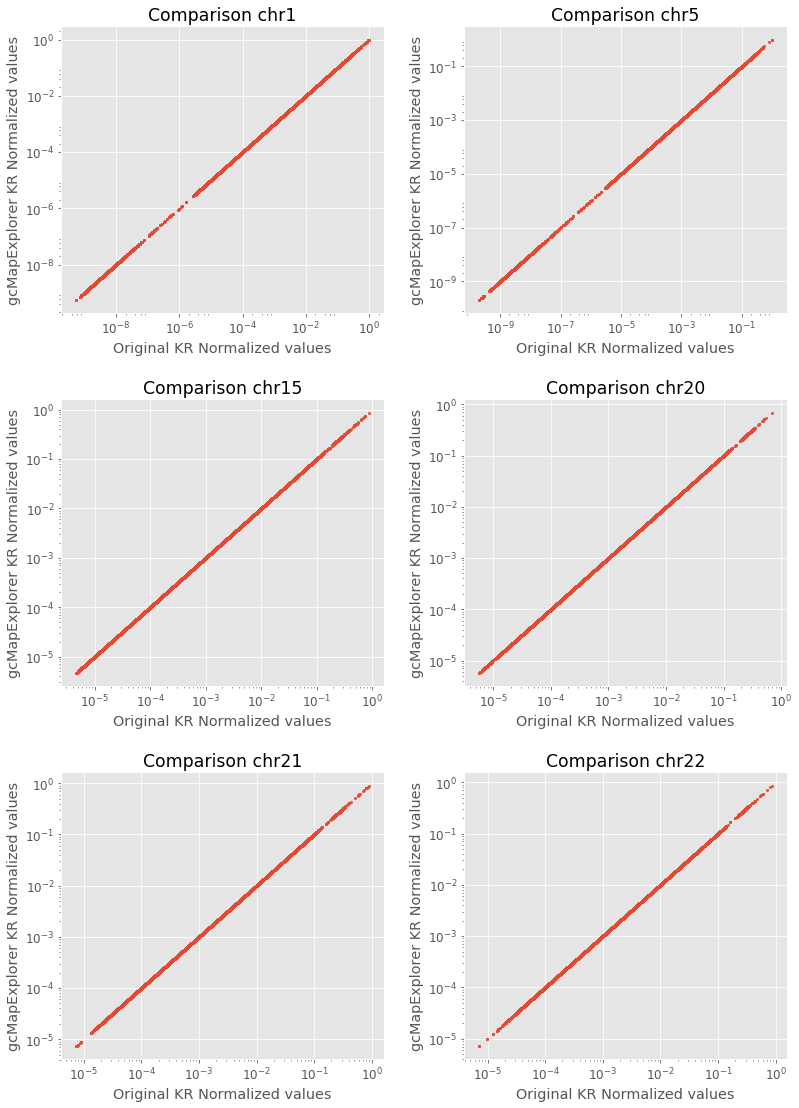

In [7]:
fig = plt.figure(figsize=(13,19))                             # Figure size
fig.subplots_adjust(hspace=0.3, wspace=0.25)                   # Space between sub-plots
mpl.rcParams.update({'font.size': 12})                        # Font-size

# Plot for chromosomes
plot_comparison_for_chromosome('chr1', fig, 1)                # For chr1
plot_comparison_for_chromosome('chr5', fig, 2)                # For chr5
plot_comparison_for_chromosome('chr15', fig, 3)               # For chr15
plot_comparison_for_chromosome('chr20', fig, 4)               # For chr20
plot_comparison_for_chromosome('chr21', fig, 5)               # For chr21
plot_comparison_for_chromosome('chr22', fig, 6)               # For chr22

plt.savefig('compare_KR.png', dpi=300)
plt.show()